# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных**

Признаки:
- **DateCrawled** — дата скачивания анкеты из базы
- **VehicleType** — тип автомобильного кузова
- **RegistrationYear** — год регистрации автомобиля
- **Gearbox** — тип коробки передач
- **Power** — мощность (л. с.)
- **Model** — модель автомобиля
- **Kilometer** — пробег (км)
- **RegistrationMonth** — месяц регистрации автомобиля
- **FuelType** — тип топлива
- **Brand** — марка автомобиля
- **Repaired** — была машина в ремонте или нет
- **DateCreated** — дата создания анкеты
- **NumberOfPictures** — количество фотографий автомобиля
- **PostalCode** — почтовый индекс владельца анкеты (пользователя)
- **LastSeen** — дата последней активности пользователя

Целевой признак:
- **Price** — цена (евро)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import make_scorer, root_mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor 
from phik import phik_matrix
from lightgbm import LGBMRegressor

In [2]:
RANDOM_STATE = 42
TEST_SIZE = 0.2

## Подготовка данных

### Предобработка данных

#### Загрузка данных

In [3]:
df = pd.read_csv("datasets/autos.csv")

In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

#### Форматирование заголовков

In [6]:
# Функция для приведения заголовков к формату snake_case
import re
def my_title_formatter(title):
    words = re.sub(r'([A-Z])', r' \1', title).split()
    return "_".join(words).lower()

In [7]:
df.columns = map(lambda x: my_title_formatter(x), df.columns)

In [8]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

#### Обработка пропусков

In [9]:
df.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

При удалении пропусков постараемся сохранить не менее 90% исходых данных.

У признака *vehicle_type* с типом кузова, пропусков больше 10% от общего количества, поэтому удолять их не стоит, а можно заменить на обозначение пропуска "NA". Признак *fuel_type* с типом топлива может быть не так сильно важен при расчете стоимости автомобиля, однако пропусков много поэтому недостающие данные тоже можно заменить на "NA". Признак *repaired* который отображает была машина в ремонте или нет имеет слишком много пропусков, удалять их нельзя, можем предположить, что если информации о ремонте нет, значит его не было и укажем в пропуске "no". У признаков *gearbox* и *model* с обозначением типа коробки передач и моделью, по 19 тысяч пропусков, логично предположить, что отсутствие этих данных может сильно исказить итоговый результат работы модели поэтому пропуски следует удалить.  

In [10]:
df[df['gearbox'].isna() | df['model'].isna()]['date_crawled'].count()

np.int64(35407)

У удаляемых наблюдений c пропусками в признаках *gearbox* и *model* есть пересечения Общее количество удаляемых наблюдений около 10% от общей выборки, что как раз укладывается в ограниечние. 

In [11]:
df = df.dropna(subset = ['gearbox', 'model'])
df['vehicle_type'] = df['vehicle_type'].fillna('NA')
df['fuel_type'] = df['fuel_type'].fillna('NA')
df['repaired'] = df['repaired'].fillna('no')
df.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

#### Обработка дубликатов

Перед удалением лишних признаков, проверим на полные дубликаты, чтобы избавиться от задвоенных анкет:

In [12]:
df.duplicated().sum()

np.int64(5)

Удалим дубликаты:

In [13]:
df = df.drop_duplicates()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 318957 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        318957 non-null  object
 1   price               318957 non-null  int64 
 2   vehicle_type        318957 non-null  object
 3   registration_year   318957 non-null  int64 
 4   gearbox             318957 non-null  object
 5   power               318957 non-null  int64 
 6   model               318957 non-null  object
 7   kilometer           318957 non-null  int64 
 8   registration_month  318957 non-null  int64 
 9   fuel_type           318957 non-null  object
 10  brand               318957 non-null  object
 11  repaired            318957 non-null  object
 12  date_created        318957 non-null  object
 13  number_of_pictures  318957 non-null  int64 
 14  postal_code         318957 non-null  int64 
 15  last_seen           318957 non-null  object
dtypes: int6

Теперь можно проверить на неявные дубликаты: 

In [15]:
# Функция для показа уникальных объектов во всех признаках типа данных object, для помощи в поиске неявных дубликатов и пропусков
def unique_objects(df):
    for col in df:
        if df[col].dtypes == 'object':
            print(df.groupby(by=col).count().iloc[:, 0])
            print('___________________________')

In [16]:
unique_objects(df)

date_crawled
2016-03-05 14:06:22    1
2016-03-05 14:06:23    1
2016-03-05 14:06:24    2
2016-03-05 14:06:25    1
2016-03-05 14:06:26    1
                      ..
2016-04-07 14:36:53    1
2016-04-07 14:36:54    1
2016-04-07 14:36:55    1
2016-04-07 14:36:56    1
2016-04-07 14:36:58    1
Name: price, Length: 250929, dtype: int64
___________________________
vehicle_type
NA             23704
bus            27081
convertible    18722
coupe          14849
other           2658
sedan          85936
small          73613
suv            10959
wagon          61435
Name: date_crawled, dtype: int64
___________________________
gearbox
auto       63036
manual    255921
Name: date_crawled, dtype: int64
___________________________
model
100         399
145          40
147         549
156         601
159         209
           ... 
yaris      1003
yeti        173
ypsilon     199
z_reihe     701
zafira     2881
Name: date_crawled, Length: 250, dtype: int64
___________________________
fuel_type
NA        

Неявных дубликатов нет.

#### Вывод

В ходе этапа подготовки данных был загружен датасет *autos.csv*, названия признаков приведены к snake_case, удалены пропуски в столбцах *gearbox* и *model*, пропуски в столбцах *vehicle_type* и *fuel_type* заменены на "NA" (Not Availible) - нет данных,  пропуски в *repaired* заменены на "no". Удалены явные дубликаты, так же удалены признаки - *date_crawled*, *date_created*, *postal_code* и *last_seen*.

### Исследовательский анализ данных

#### Количественные признаки

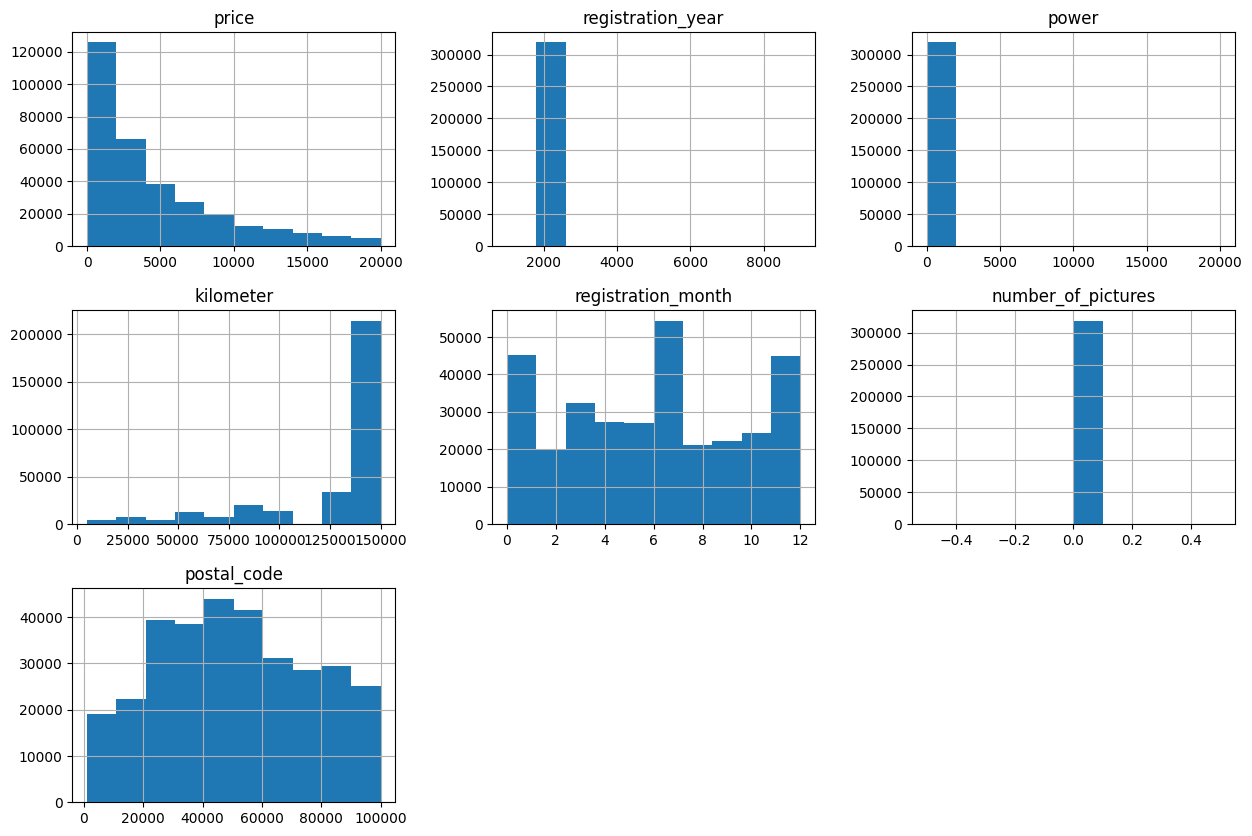

In [17]:
df.hist(figsize=(15, 10));

Целевой признак *price* имеет аномально низкие значения стоимости машин:  

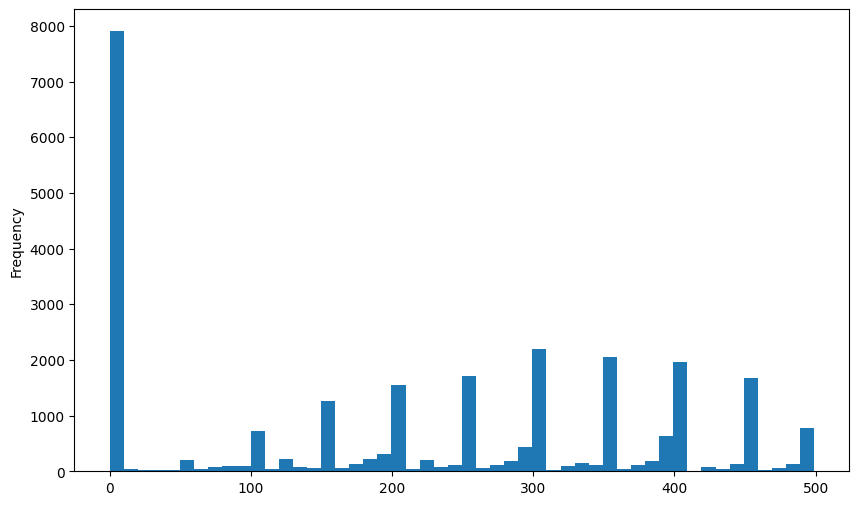

In [18]:
df.query('price < 500')['price'].plot(kind='hist', bins=50, figsize=(10, 6))
plt.show()

На графике видно большой пик в районе 0 евро за машину, в целом все цены меньше 200-400 евро выглядят слишком низкими, однако чтобы не удалять слишком много данных, избавимся только от тех что ниже 100 евро:

In [19]:
print('Размер до удаления: ', df.shape)
df = df.query('price >= 100')
print('Размер после удаления: ', df.shape)

Размер до удаления:  (318957, 16)
Размер после удаления:  (310465, 16)


У признака *registration_year* есть очевидные аномальные значения - вплоть до 8200 года по верхней границе и 1000 год по нижней. Следует точно установить верхнюю границу регистрации. Машина не может быть зарегистрирована в год позже года выгрузки анкеты с сайта.

In [20]:
df['registration_year'].describe()

count    310465.000000
mean       2003.446843
std          25.080106
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        8200.000000
Name: registration_year, dtype: float64

In [21]:
pd.Series(pd.DatetimeIndex(pd.to_datetime(df["date_crawled"], format='%Y-%m-%d %H:%M:%S')).year).describe()

count    310465.0
mean       2016.0
std           0.0
min        2016.0
25%        2016.0
50%        2016.0
75%        2016.0
max        2016.0
Name: date_crawled, dtype: float64

Все анкеты выгружены в 2016 году, значит верхняя граница 2016 год включительно.

In [22]:
df.query('registration_year > 2016')['price'].count()

np.int64(10510)

Так-же на графике видны аномалии в меньшую сторону возьмем за нижнюю границу 1910 год:

In [23]:
df.query('registration_year < 1910')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
18224,2016-03-09 17:49:44,7999,NA,1500,manual,224,impreza,5000,3,NA,subaru,no,2016-03-09 00:00:00,0,53577,2016-03-15 05:15:17
56241,2016-03-30 18:54:27,950,NA,1400,manual,1400,golf,125000,4,petrol,volkswagen,no,2016-03-30 00:00:00,0,50389,2016-04-03 09:45:19
189722,2016-03-29 16:56:41,1500,NA,1000,manual,0,kaefer,5000,0,petrol,volkswagen,no,2016-03-29 00:00:00,0,48324,2016-03-31 10:15:28
287304,2016-03-09 15:54:00,500,NA,1602,manual,0,other,5000,0,NA,bmw,yes,2016-03-09 00:00:00,0,30900,2016-03-10 12:17:35
340759,2016-04-04 23:55:47,700,NA,1600,manual,1600,a3,150000,4,petrol,audi,no,2016-04-04 00:00:00,0,86343,2016-04-05 06:44:07


Аномалии в мощности оценить уже сложнее, построим боксплот, с ограничением в 600 по оси Y (лошадиные силы):

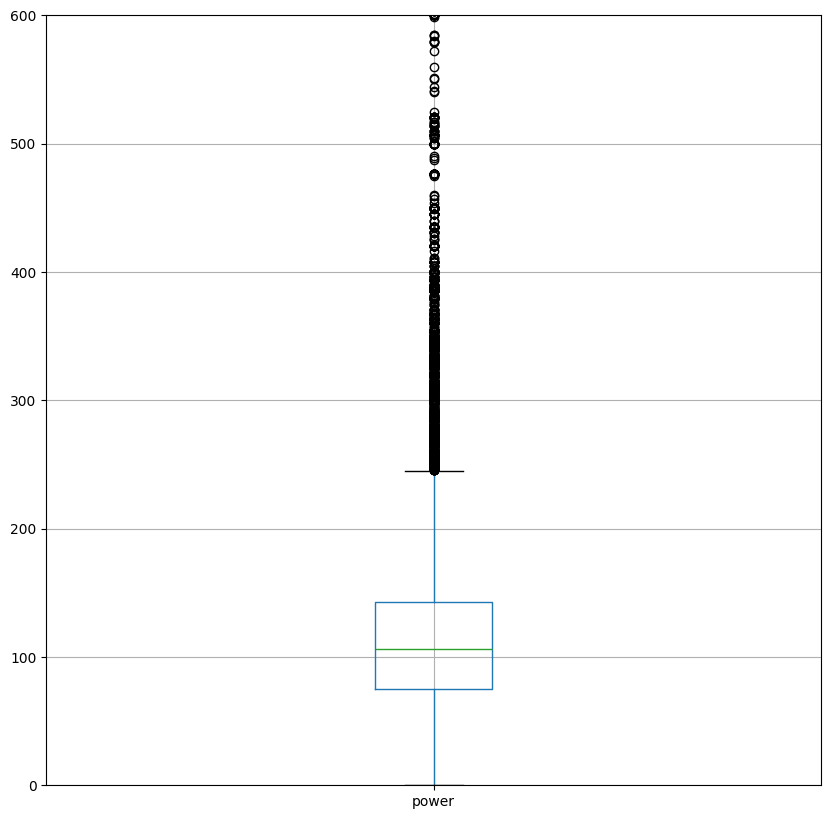

In [24]:
df.boxplot('power', figsize=(10, 10))
plt.ylim(0, 600)
plt.show()

In [25]:
display(df.query('power > 350').head(10))
df.query('power > 350')['price'].count()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
1816,2016-03-22 20:52:00,3200,small,2004,manual,1398,corolla,5000,6,petrol,toyota,no,2016-03-22 00:00:00,0,22043,2016-03-22 21:43:26
2406,2016-03-08 17:44:18,13500,NA,2006,auto,396,5er,150000,10,NA,bmw,no,2016-03-08 00:00:00,0,49696,2016-03-27 11:17:40
2781,2016-03-16 00:37:16,19500,suv,2004,auto,450,cayenne,125000,12,petrol,porsche,no,2016-03-16 00:00:00,0,38448,2016-04-01 22:47:31
2901,2016-03-30 11:41:34,12900,sedan,2006,auto,387,s_klasse,150000,7,petrol,mercedes_benz,no,2016-03-30 00:00:00,0,47443,2016-04-01 05:15:43
3245,2016-04-02 21:57:12,15500,sedan,2006,auto,387,s_klasse,150000,2,petrol,mercedes_benz,no,2016-04-02 00:00:00,0,59065,2016-04-06 23:45:57
3289,2016-03-10 17:46:47,16899,wagon,2003,auto,476,e_klasse,150000,9,petrol,mercedes_benz,no,2016-03-10 00:00:00,0,44319,2016-04-03 18:47:41
4060,2016-04-03 20:31:00,3100,sedan,2005,manual,953,colt,150000,4,gasoline,mitsubishi,no,2016-04-03 00:00:00,0,60326,2016-04-07 14:56:46
4681,2016-03-25 17:57:37,13900,sedan,2006,auto,476,e_klasse,150000,5,petrol,mercedes_benz,no,2016-03-25 00:00:00,0,52078,2016-04-06 23:17:21
4827,2016-03-26 14:44:10,15500,sedan,2004,auto,367,c_klasse,150000,6,petrol,mercedes_benz,no,2016-03-26 00:00:00,0,73312,2016-04-02 04:17:22
5319,2016-03-27 17:57:40,10999,wagon,2006,auto,435,other,150000,12,petrol,audi,yes,2016-03-27 00:00:00,0,52249,2016-04-01 19:17:31


np.int64(1002)

Данные о мощности машин выше 350 л.с. выглядят подозрительно, где-то ошибки очевидны, в целом таких данных очень мало, их смело можно удалить. 

Удалим аномальные значения по году регистрации и мощности автомобилей:

In [26]:
df.shape

(310465, 16)

In [27]:
df = df.query('1910 <= registration_year <= 2016 and power <= 350')

In [28]:
df.shape

(298978, 16)

In [29]:
display(df.query('1 <= power < 10').head(10))
df.query('1 <= power < 10')['price'].count()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
9561,2016-04-04 07:58:34,9000,sedan,2009,manual,2,a4,5000,12,gasoline,audi,no,2016-04-04 00:00:00,0,12045,2016-04-06 10:17:01
20229,2016-03-17 22:48:49,4999,sedan,2003,manual,1,e_klasse,150000,12,gasoline,mercedes_benz,no,2016-03-17 00:00:00,0,66571,2016-03-17 23:44:50
33068,2016-03-29 15:44:33,5950,small,2004,manual,4,golf,80000,7,petrol,volkswagen,no,2016-03-29 00:00:00,0,64285,2016-04-06 01:15:51
33223,2016-03-23 12:55:57,3900,convertible,2004,auto,1,forfour,90000,5,petrol,smart,no,2016-03-23 00:00:00,0,85386,2016-04-05 12:45:16
33995,2016-04-02 20:54:41,4999,small,2012,auto,5,other,5000,10,electric,renault,no,2016-04-02 00:00:00,0,38315,2016-04-06 22:16:21
34378,2016-03-18 19:45:27,655,NA,1995,manual,5,other,70000,0,NA,seat,no,2016-03-18 00:00:00,0,66459,2016-03-18 19:45:27
37733,2016-03-23 21:56:02,1300,wagon,1999,auto,9,other,30000,3,petrol,citroen,no,2016-03-23 00:00:00,0,79102,2016-04-06 04:17:13
42961,2016-04-03 20:58:00,4200,other,2012,auto,8,other,40000,12,electric,renault,no,2016-04-03 00:00:00,0,75053,2016-04-03 20:58:00
44179,2016-04-02 17:52:18,500,small,1998,auto,7,1_reihe,100000,11,petrol,peugeot,no,2016-04-02 00:00:00,0,66271,2016-04-02 17:52:18
49038,2016-03-21 16:54:14,750,NA,2000,manual,4,golf,125000,0,petrol,volkswagen,no,2016-03-21 00:00:00,0,39418,2016-03-25 14:16:40


np.int64(50)

Данных где мощность двигателя равна 0 л.с., могут относиться к машинам без двигателя, однако те машины, чья мощность от 1 до 9 л.с. включтельно, выглядят подозрительно их немного и их можно удалить:

In [30]:
df.shape

(298978, 16)

In [31]:
df = df.query('power == 0 or power > 9')

In [32]:
df.shape

(298928, 16)

Удалим не нужные признаки:

Такие "технические" признаки как дата скачивания анкеты из базы, дата создания анкеты, почтовый индекс владельца анкеты (пользователя), дата последней активности пользователя не имеют смысла в предсказовании цены автомобиля. Признак *number_of_pictures* состоит только из нулей. Все вышеперечисленные признаки можно удалить. Месяц регистрации машины не так важен как год, однако на всякий случай можно его оставить до корреляционного анализа.

In [33]:
df = df.drop(['date_crawled', 'date_created', 'postal_code', 'last_seen', 'number_of_pictures'], axis=1)

In [34]:
df.shape

(298928, 11)

Проведем анализ:

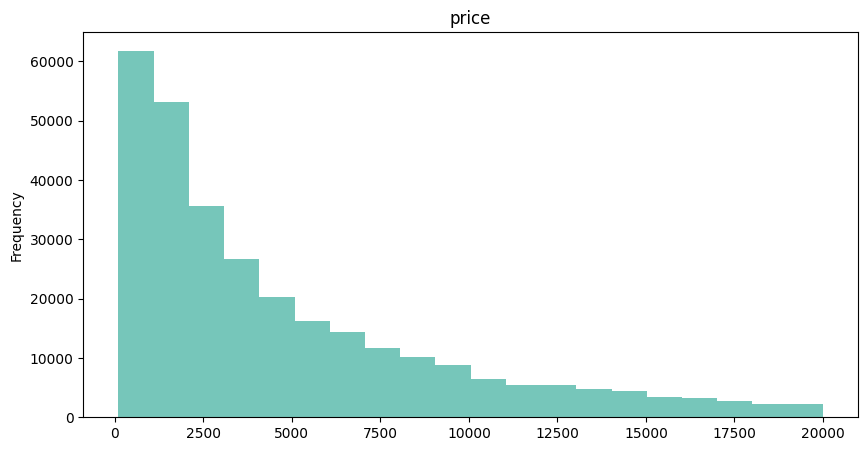

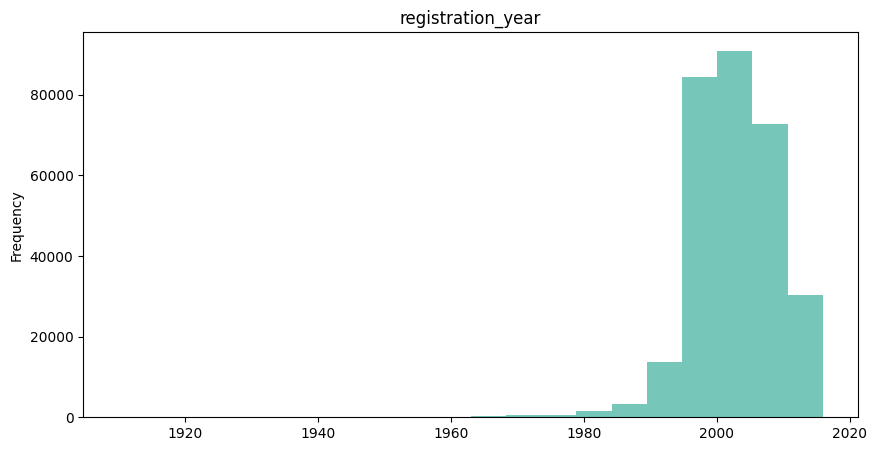

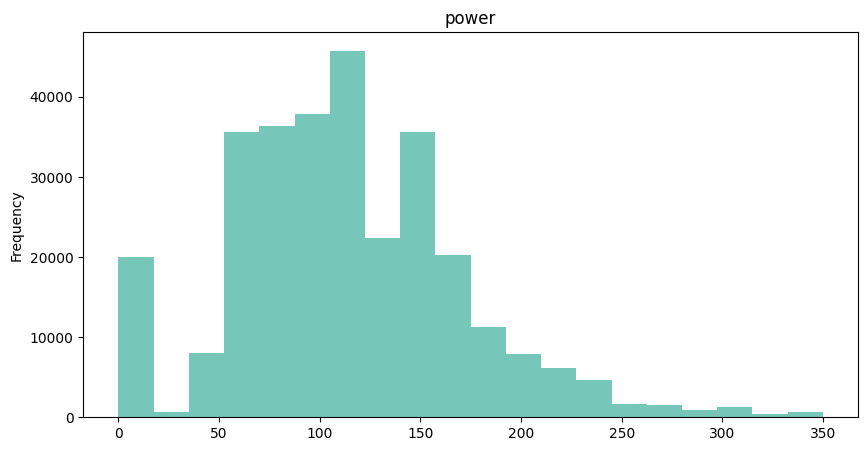

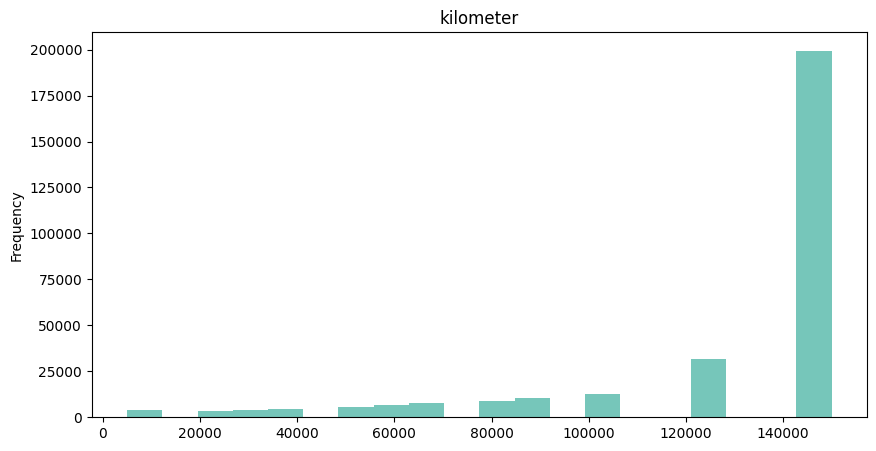

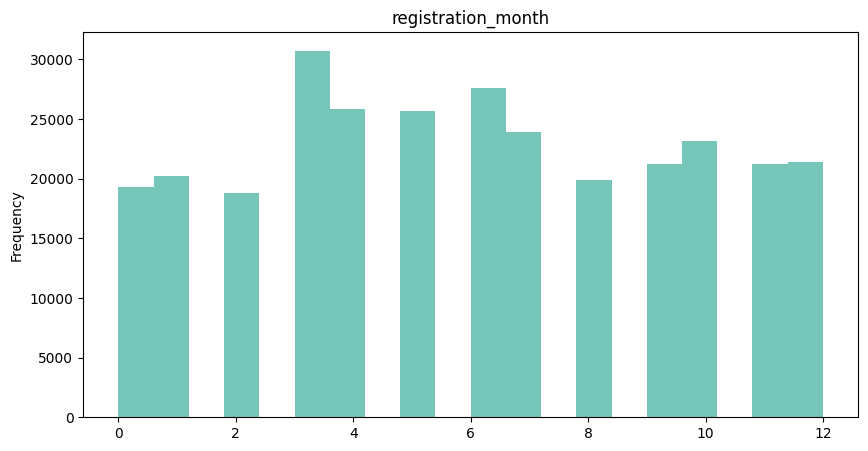

               price  registration_year          power      kilometer  \
count  298928.000000      298928.000000  298928.000000  298928.000000   
mean     4761.602771        2002.812651     112.322151  128606.487181   
std      4568.795122           6.462718      58.011210   36568.904133   
min       100.000000        1910.000000       0.000000    5000.000000   
25%      1300.000000        1999.000000      75.000000  125000.000000   
50%      3000.000000        2003.000000     107.000000  150000.000000   
75%      6900.000000        2007.000000     143.000000  150000.000000   
max     20000.000000        2016.000000     350.000000  150000.000000   

       registration_month  
count       298928.000000  
mean             5.975743  
std              3.598959  
min              0.000000  
25%              3.000000  
50%              6.000000  
75%              9.000000  
max             12.000000  


In [35]:
for col in ["price", "registration_year", "power", "kilometer", "registration_month"]:
    df[col].plot(
        kind='hist', 
        bins=20, 
        title=col, 
        figsize=(10, 5),
        color=sns.color_palette("BrBG")[4])
    plt.show()
print(df.describe())

Средняя стоимость автомобилей составляет 4700 евро, медианная 3000 евро. Большенство регистраций автомобилей приходится на середину 2000-ых. Средняя мощность всех автомобилей около 120 л.с., средний пробег 128000 км., подавлющее большенство машин имеют пробег в 150000 км.. По месяцам регистрации данные распределены относительно равномерно.

#### Категориальные признаки

In [36]:
# Функция для постраения круговой диаграммы
def my_pie_plot(df, col, title=None, legend=False, figsize=(12, 12), show_data=False):
    if title == None:
        title = col.replace('_', ' ').capitalize()
        
    res = df.groupby(by=col).count().iloc[:, 0].sort_values(ascending=False)
    if len(res) >= 20:
        try:
            other = res["other"] + res[19:].sum()
            res = res.drop("other") 
        except:
            other = res[19:].sum()
        res = res[:19]
        res["other"] = other
        res.sort_values(ascending=False)
    res.plot(
        kind='pie', 
        autopct='%1.0f%%', 
        subplots=True,
        figsize=figsize,
        colors=sns.color_palette('BrBG'),
        textprops={'fontsize':14},
        legend=legend)
    
    plt.title(title,  fontdict = {'fontsize' : 15})
    plt.show()
    if show_data == True:
        return display(res)

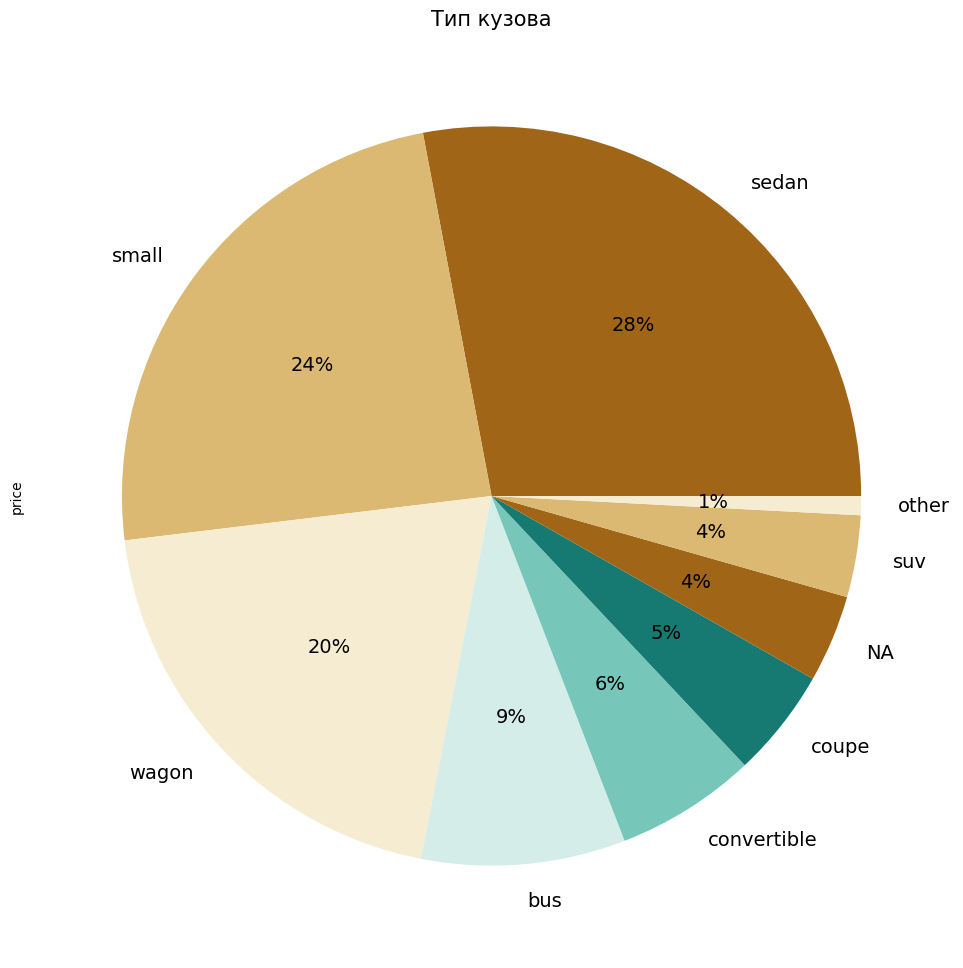

In [37]:
my_pie_plot(df, 'vehicle_type', title='Тип кузова')

Три самых популярных типа кузова занимают 69% от общей выборки машин - это седаны - 27%, хэтчбеки (small) - 23%, универсалы (wagon) - 19%.

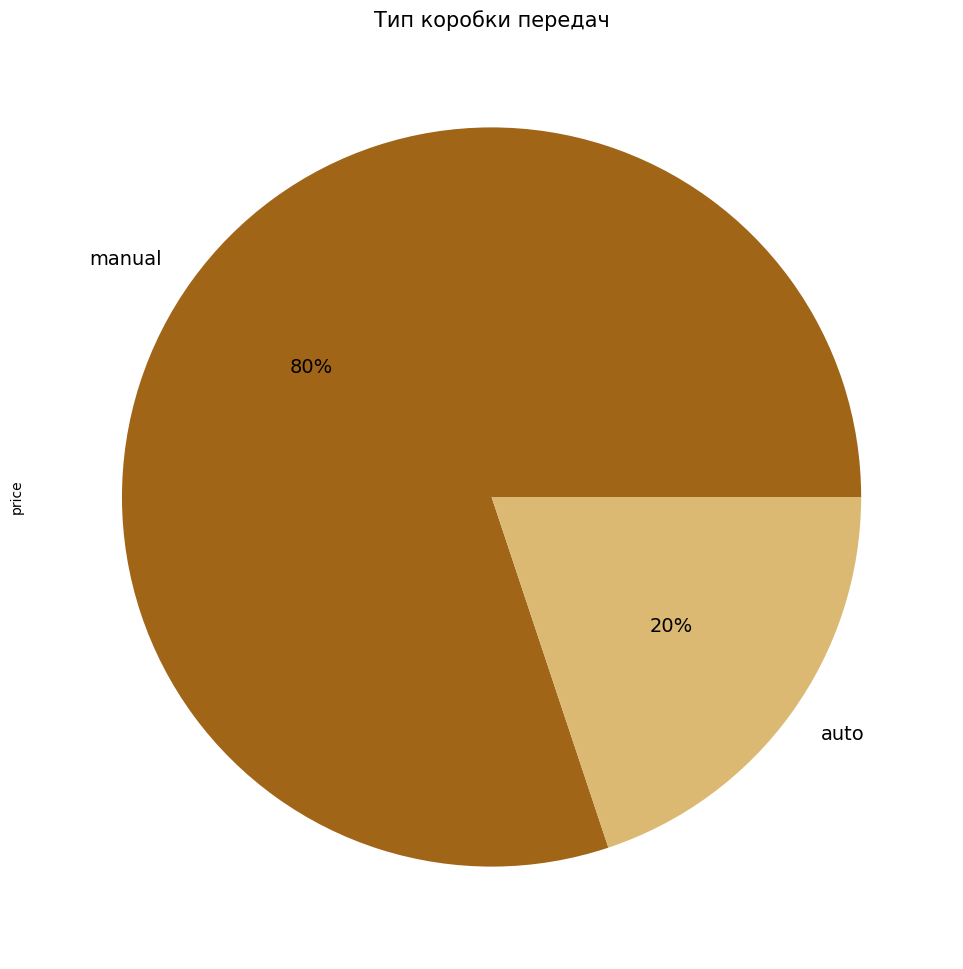

In [38]:
my_pie_plot(df, 'gearbox', title='Тип коробки передач')

80% машин имеют механическую коробку передач, остальные 20% коробку автомат.

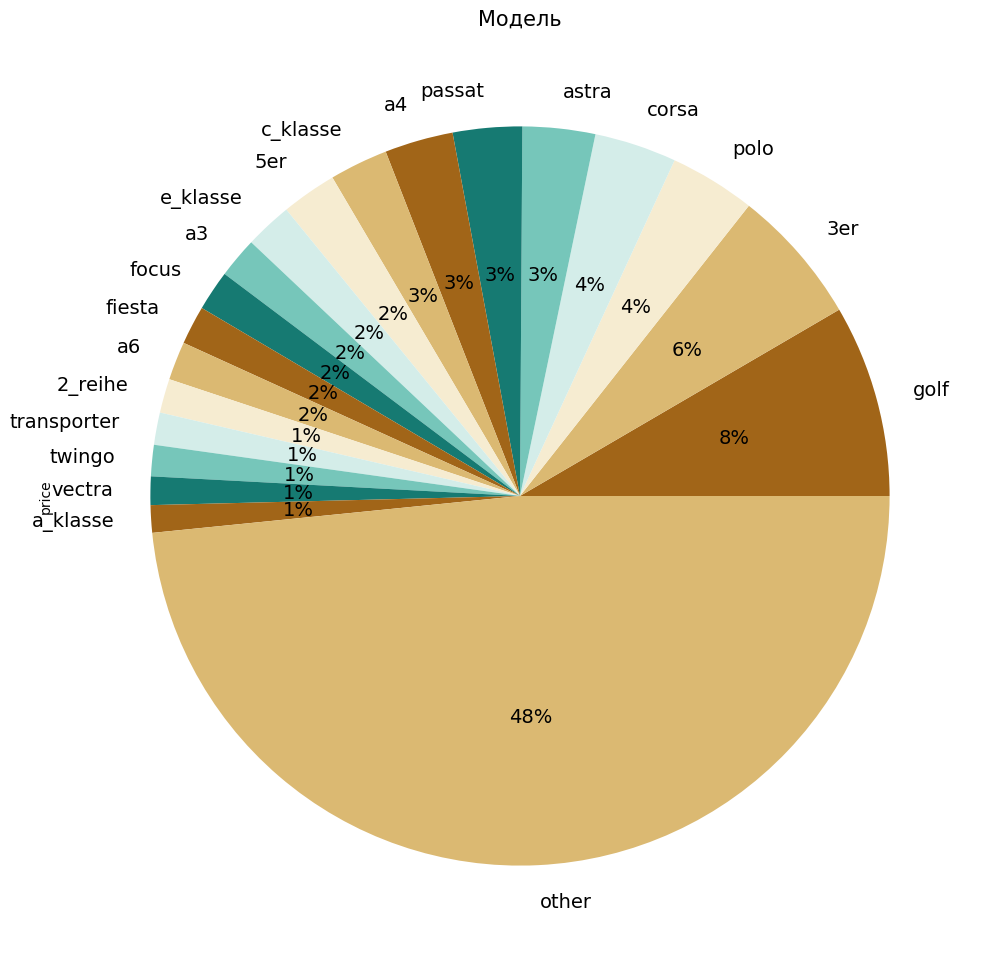

In [39]:
my_pie_plot(df, 'model', title='Модель')

Самая популярная модель машины на сайте это Volkswagen Golf - 9%, затем идет BMW 3er - 6%, на 3 месте Volkswagen Polo и Opel Corsa - по 4%.

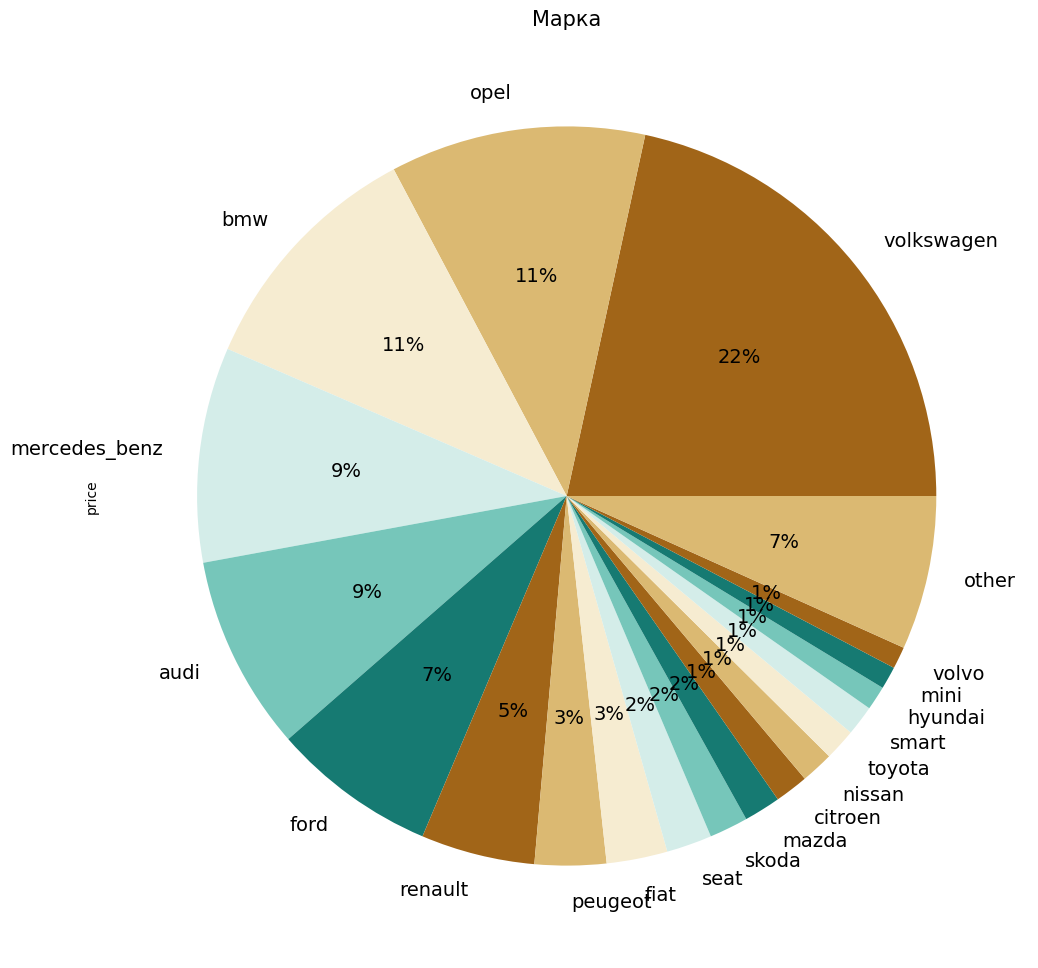

In [40]:
my_pie_plot(df, 'brand', title='Марка')

Среди марок на первом месте, с двухкратным отрывом от второго идет Volkswagen - 22%, на втором месте Opel и BMW - по 11%, на третьем месте Mercedes-Benz - 9%.

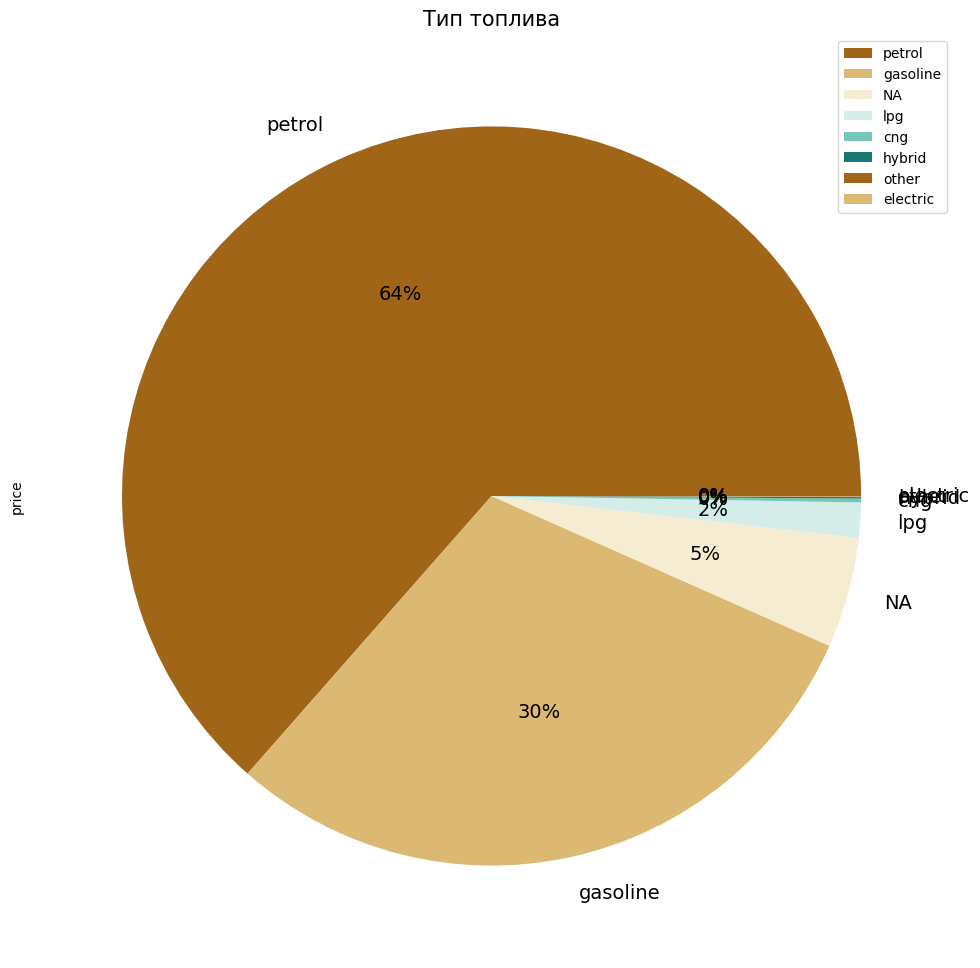

fuel_type
petrol      189893
gasoline     89178
NA           14432
lpg           4591
cng            497
hybrid         194
other           89
electric        54
Name: price, dtype: int64

In [41]:
my_pie_plot(df, 'fuel_type', title='Тип топлива', legend=True, show_data=True)

"Petrol" и "Gasoline" - это обычный бензин, который в разных регионах называют по разному, в сумме они дают 91%, возможность объединения этих показателей, как и важость всего признака "fuel_type", можно будет рассмотреть на этапе обучения модели при необходимости. На втором месте идет пропан (lpg) с 2%, остальные типы топлива составляют около 0,001% от общей выборки.

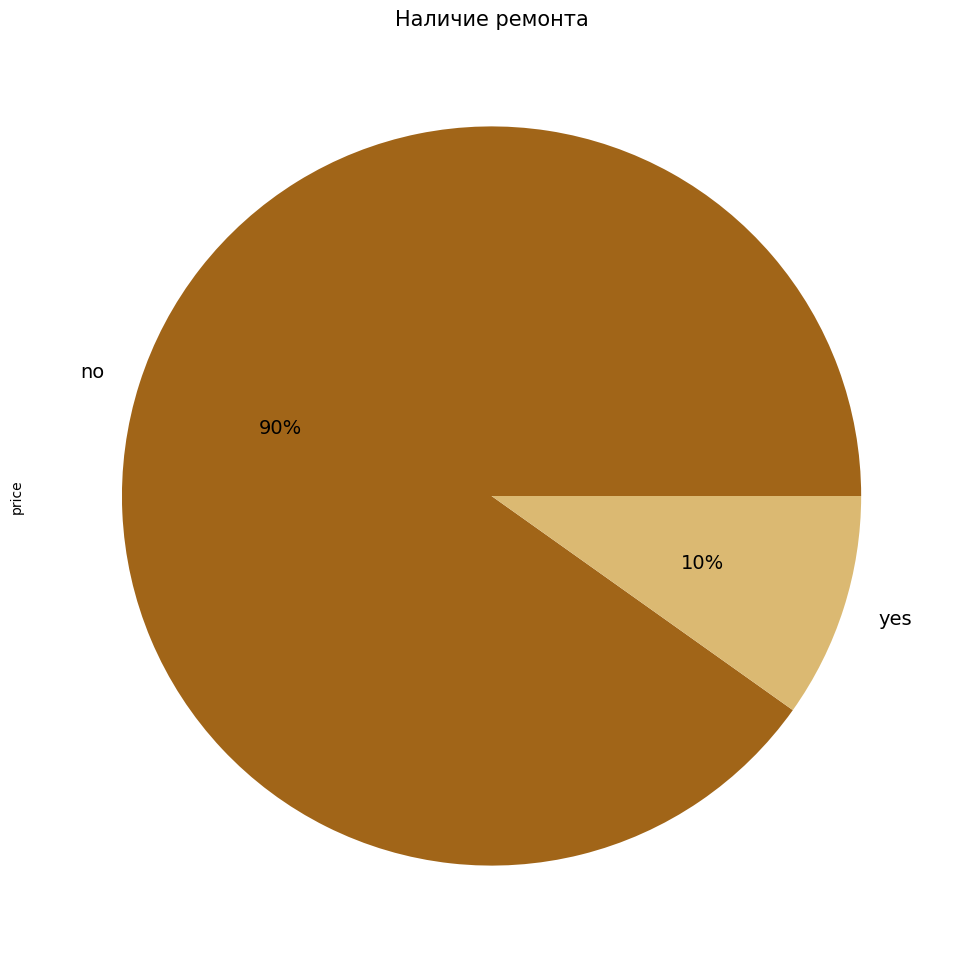

In [42]:
my_pie_plot(df, 'repaired', title='Наличие ремонта')

Каждая десятая машина была в ремонте.

#### Корреляционный анализ

При составлении phik матрицы необходимо указать количественные признаки (interval_cols) так как год и месяц регистрации можно рассмотреть как категориальные, то имеет смысл не относить их к количественным признакам при построении матрицы корреляции. 

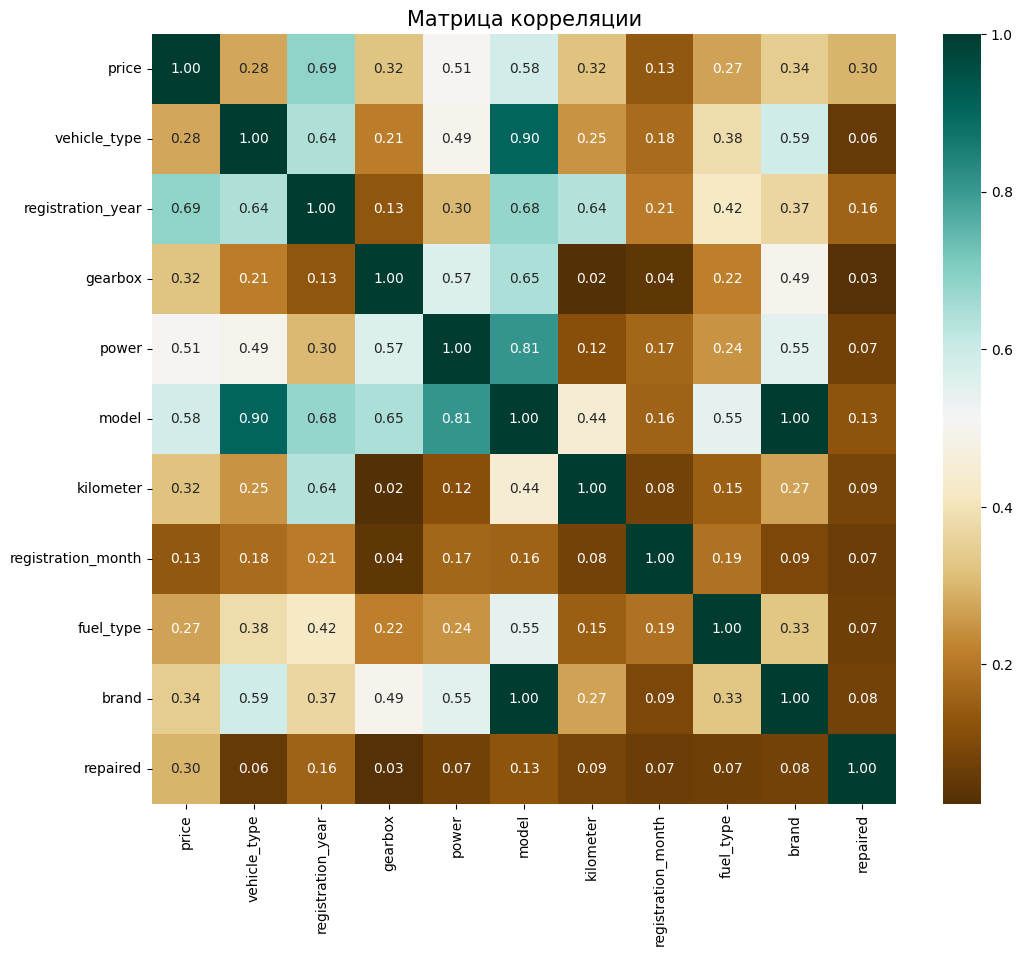

In [43]:
plt.figure(figsize=(12,10), dpi= 100)
sns.heatmap(
    df.phik_matrix(interval_cols=["price", "power", "kilometer"]), 
    annot = True, 
    fmt=".2f", 
    cmap='BrBG'
)
plt.title('Матрица корреляции', fontdict = {'fontsize' : 15})
plt.show()

По матрице корреляций видно, что признак модели (*model*) и марки (*brand*) машины коррелируют на 100%, в то же время признак  *model* имеет заметную корреляцию с целевым признаком *price* - 0.59. Лучше всего с целевым признаком коррелирует признак *registration_year* - 0.68. Ожидаемо самая низкая корреляция с целевым признаком, на уровне погрешности, у *registration_month* - 0.14. Так же целевой признак имеет умеренную корреляцию с признаком *power* - 0.48. Между собой имеют сильную корреляцию признаки *model* и *vehicle_type* - 0.90 и *model* с *power* - 0.83.

#### Вывод

Средняя стоимость автомобилей составляет 4700 евро. Большенство автомобилей зарегестрированы в середине 2000-ых. Средняя мощность всех автомобилей около 120 л.с., а пробег 128000 км., подавлющее большенство машин имеют пробег в 150000 км.

Три самых популярных типа кузова занимают 69% от общей выборки машин - это седаны, хэтчбеки и универсалы. 80% машин имеют механическую коробку передач, остальные 20% коробку автомат.

Самые популярные модели машин на сайте - это Volkswagen Golf, BMW 3er, Volkswagen Polo и Opel Corsa. Самые популярные  марки - Volkswagen, Opel, BMW и Mercedes-Benz. Каждая десятая машина была в ремонте. Минимум 91% машин на бензине.

По итогам корреляционного анализа признаки *brand* и *registration_month* при обучении модели использоваться не будут. Самые коррелируемые признаки с целевым - это *registration_year* - 0.68 и *model* - 0.59.

## Обучение моделей

### Подготовка данных и метрик

In [44]:
result_data = df.drop(["brand", "registration_month"], axis=1)
result_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 298928 entries, 0 to 354368
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              298928 non-null  int64 
 1   vehicle_type       298928 non-null  object
 2   registration_year  298928 non-null  int64 
 3   gearbox            298928 non-null  object
 4   power              298928 non-null  int64 
 5   model              298928 non-null  object
 6   kilometer          298928 non-null  int64 
 7   fuel_type          298928 non-null  object
 8   repaired           298928 non-null  object
dtypes: int64(4), object(5)
memory usage: 22.8+ MB


In [45]:
cat_col_names = ["vehicle_type", "gearbox", "model", "fuel_type", "repaired"]
num_col_names = ["registration_year", "power", "kilometer"]

In [46]:
X = result_data.drop("price", axis=1)
y = result_data["price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size = TEST_SIZE,
    random_state=RANDOM_STATE
)

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)

X_train_ord = encoder.fit_transform(X_train[cat_col_names])
X_test_ord = encoder.transform(X_test[cat_col_names])

# encoder_col_names = encoder.get_feature_names()

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_ord = pd.DataFrame(X_train_ord, columns=cat_col_names)
X_test_ord = pd.DataFrame(X_test_ord, columns=cat_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ord, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ord, X_test_scaled], axis=1)

In [47]:
def rmse_func(y_true, y_pred):
    return root_mean_squared_error(y_true, y_pred)

rmse_score = make_scorer(
    rmse_func,
    greater_is_better=False)

In [48]:
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

### Обучение моделей

В ходе данного шага, с помощью кроссвалидации, будут обучены 2 регрессионные модели:
- Модель градиентного бустинга - *LGBMRegressor*
- Модель дерева решений - *DecisionTreeRegressor*

Критерием успеха считается оценка RMSE предсказания модели на тестовой выборке меньше 2500.

#### Модель градиентного бустинга

In [49]:
gbm_params = {'max_depth': [-1, 3, 5, 7, 9],
              'num_leaves': [10, 20, 30, 40, 50]}

In [50]:
gbm_grid = GridSearchCV(
    LGBMRegressor(), 
    gbm_params,
    scoring=rmse_score,
    cv=cv,
    n_jobs=-1
)

In [51]:
%%time
gbm_grid.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 573
[LightGBM] [Info] Number of data points in the train set: 239142, number of used features: 8
[LightGBM] [Info] Start training from score 4764.652591
CPU times: total: 2.34 s
Wall time: 18.4 s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'max_depth': [-1, 3, 5, 7, 9],
                         'num_leaves': [10, 20, 30, 40, 50]},
             scoring=make_scorer(rmse_func, greater_is_better=False, response_method='predict'))

In [52]:
gbm_res = pd.DataFrame(gbm_grid.cv_results_).sort_values(by="rank_test_score")

In [53]:
print("Среднее время обучения модели:", gbm_res["mean_fit_time"].iloc[0].round(2), "сек.")

Среднее время обучения модели: 4.1 сек.


In [54]:
print("Среднее время предсказания модели:", gbm_res["mean_score_time"].iloc[0].round(2), "сек.")

Среднее время предсказания модели: 0.04 сек.


In [55]:
print("Лучший результат RMSE на кросс-валидации:", int(gbm_grid.best_score_))

Лучший результат RMSE на кросс-валидации: -1663


#### Модель дерева решений

In [56]:
tree_params = {
    'max_depth': range(5, 15),
    'max_features': range(5, 8),
    'min_samples_split': range(5, 10),
    'min_samples_leaf': range(1, 5)}

In [57]:
dtr_grid = GridSearchCV(
    DecisionTreeRegressor(random_state=RANDOM_STATE), 
    tree_params,
    scoring=rmse_score,
    cv=cv,
    n_jobs=-1
)

In [58]:
%%time
dtr_grid.fit(X_train, y_train)

CPU times: total: 15.1 s
Wall time: 1min 13s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(5, 15), 'max_features': range(5, 8),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(5, 10)},
             scoring=make_scorer(rmse_func, greater_is_better=False, response_method='predict'))

In [59]:
dtr_res = pd.DataFrame(dtr_grid.cv_results_).sort_values(by="rank_test_score")

In [60]:
print("Среднее время обучения модели:", dtr_res["mean_fit_time"].iloc[0].round(2), "сек.")

Среднее время обучения модели: 0.35 сек.


In [61]:
print("Среднее время предсказания модели:", dtr_res["mean_score_time"].iloc[0].round(2), "сек.")

Среднее время предсказания модели: 0.01 сек.


In [62]:
print("Лучший результат RMSE на кросс-валидации:", int(dtr_grid.best_score_))

Лучший результат RMSE на кросс-валидации: -1841


## Анализ моделей

Результат первой модели - *LGBMRegressor*:
- Оценка RMSE - -1663
- Время обучения - 5.5с
- Время предсказания - 0.5с

Результат второй модели - *DecisionTreeRegressor*:
- Оценка RMSE - -1841
- Время обучения - 0.34с
- Время предсказания - 0.1с

Первая модель показала лучший RMSE -1663 против -1841, но вторая модель обучилась в несколько раз быстрее, 0.34с против 5.5с, и в 5 раз быстрее сделала предсказание, за 0.1 секунду против 0.5. Использование градиентного бустинга более затратно по ресурсам, чем использование дерева решений, но градиентный бустинг дает более точный результат, поэтому стоит остановиться на модели *LGBMRegressor*.

Сделаем предсказание на тестовой выборке и рассчитаем RMSE:

In [63]:
gbm_model = gbm_grid.best_estimator_
gbm_pred = gbm_model.predict(X_test)

In [65]:
rmse_gbm = root_mean_squared_error(y_test, gbm_pred)
print("Результат RMSE на тестовой выборке:", int(rmse_gbm))

Результат RMSE на тестовой выборке: 1662


<Axes: >

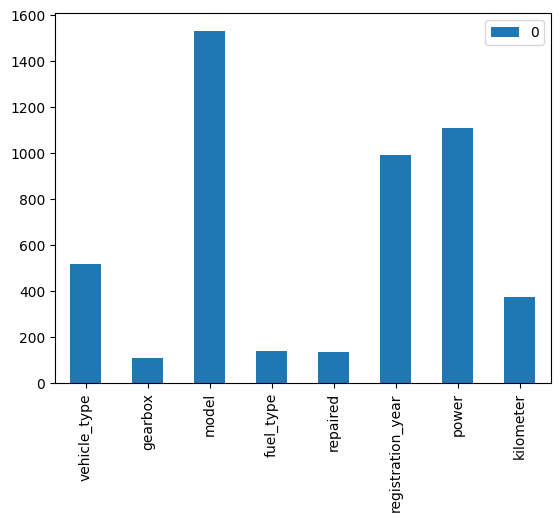

In [67]:
pd.DataFrame(index=X_train.columns, data=gbm_model.feature_importances_).plot(kind='bar')